In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
%cd ~\OneDrive\Documents\thebrand

C:\Users\igari\OneDrive\Documents\thebrand


# Project objective: Demand forecast (unit sales) for potential new products for "The Brand"

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.utils.constants import TARGET, MODEL_FEATURES
from src.utils.funcs import get_nrf_color_group

import warnings

warnings.filterwarnings("ignore")

In [4]:
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [5]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# A note on choice of models

Model requirements:
   - Should be able to detect interactions without coding for interaction features
   - Should be able to handle new values of categorical features
   - Should be able to handle feature selection
   - Should generalise well and be less prone to overfitting

Decision trees are generally better at uncovering feature interactions without explicitly coding for them. Therefore, in interest of time, we will skip testing linear regression models but ideally, this should be done.

# Read in training data

In [6]:
MODEL_FEATURES

['MATERIAL_CONTENT_CODE',
 'PRODUCT_TYPES',
 'BUSINESS_SEGMENTS',
 'Sustainablity',
 'MARKETING_CATEGORY',
 'nrf_color_group']

In [7]:
train_path = data / "01_raw" / "train_raw.csv"
train = pd.read_parquet(train_path)

y_train = train.loc[:, [TARGET]]
X_train = train.loc[:, MODEL_FEATURES]

X_train.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,Sustainablity,MARKETING_CATEGORY,nrf_color_group
0,74.57,77.91,78.29,1,76.11,1
1,74.46,71.53,74.19,1,75.26,1
2,74.46,74.32,73.74,2,78.03,2
3,74.81,75.95,75.56,3,103.96,3
4,58.49,61.56,74.13,4,57.53,1


# Test data preprocessing

In [8]:
test_path = data / "01_raw" / "test_raw.csv"
test = pd.read_parquet(test_path)
test.shape

(12124, 7)

In [9]:
# Outlier removal at 216.0
test = test[test.Units_sold < 216]

# Feature nrf color group
test["nrf_color_group"] = test.apply(get_nrf_color_group, axis=1)

# Categorical encoding
oe_encoder_path = base_dir / "artifacts" / "oe_encoder.pkl"
file = open(oe_encoder_path, "rb")
oe_encoder = pickle.load(file)
test = oe_encoder.transform(test)

encoder_path = base_dir / "artifacts" / "encoder.pkl"
file2 = open(encoder_path, "rb")
encoder = pickle.load(file2)
test = encoder.transform(test)
test.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold,nrf_color_group
233,74.16,74.46,73.80,100.00,1,71.59,72,2
234,74.90,74.46,74.13,834.00,1,76.55,132,10
235,76.89,74.46,73.46,100.00,3,74.76,72,2
236,74.24,74.59,73.52,610.00,9,69.97,96,4
237,74.16,74.46,76.90,80.00,5,72.08,36,6


In [10]:
y_test = test.loc[:, [TARGET]]
X_test = test.loc[:, MODEL_FEATURES]

X_train.to_parquet(data / "02_intermediate/X_train.csv", index=None)
X_test.to_parquet(data / "02_intermediate/X_valid.csv", index=None)
y_train.to_parquet(data / "02_intermediate/y_train.csv", index=None)
y_test.to_parquet(data / "02_intermediate/y_valid.csv", index=None)

We will use evaluation metric: MAE

# Comparing various algorithms

Let us see whether bagging does better or boosting in this problem

## Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   58.2s


Training MAE: 30.669087704748083
Test MAE: 35.263752177158494
Training MAPE: 0.8057302136572825
Test MAPE: 0.9262040593563579


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot:>

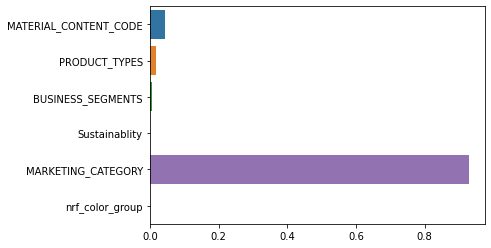

In [11]:
#Only using a few params here to test the model
est_rf = RandomForestRegressor(
    criterion="absolute_error", max_depth=5, verbose=1, n_jobs=-1
)

est_rf.fit(
    X_train.loc[:, MODEL_FEATURES],
    np.array(y_train).reshape(
        -1,
    ),
)

rf_pred_train = est_rf.predict(X_train[MODEL_FEATURES])
rf_pred_test = est_rf.predict(X_test[MODEL_FEATURES])

print(f"Training MAE: {mean_absolute_error(y_train, rf_pred_train)}")
print(f"Test MAE: {mean_absolute_error(y_test, rf_pred_test)}")

print(f"Training MAPE: {mean_absolute_percentage_error(y_train, rf_pred_train)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, rf_pred_test)}")

sns.barplot(x=est_rf.feature_importances_, y=MODEL_FEATURES)

## Gradient Boosting Regressor

      Iter       Train Loss   Remaining Time 
         1          32.9282            3.69s
         2          32.6248            4.12s
         3          32.3509            4.70s
         4          32.0948            4.42s
         5          31.8823            4.59s
         6          31.7020            4.44s
         7          31.5489            4.39s
         8          31.4240            4.32s
         9          31.3150            4.27s
        10          31.2210            4.31s
        20          30.7285            3.77s
        30          30.5646            3.28s
        40          30.4925            2.80s
        50          30.4418            2.33s
        60          30.4226            1.86s
        70          30.4051            1.40s
        80          30.3964            0.94s
        90          30.3905            0.47s
       100          30.3853            0.00s
Training MAE: 30.38534286033892
Test MAE: 34.97746762922169
Training MAPE: 0.8055968066643733
Test 

<AxesSubplot:>

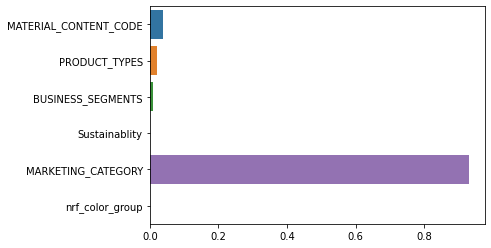

In [12]:
#Only using a few params here to test the model
est_gb = GradientBoostingRegressor(max_depth=5, loss="absolute_error", verbose=1)

est_gb.fit(
    X_train.loc[:, MODEL_FEATURES],
    np.array(y_train).reshape(
        -1,
    ),
)

gb_pred_train = est_gb.predict(X_train[MODEL_FEATURES])
gb_pred_test = est_gb.predict(X_test[MODEL_FEATURES])

print(f"Training MAE: {mean_absolute_error(y_train, gb_pred_train)}")
print(f"Test MAE: {mean_absolute_error(y_test, gb_pred_test)}")

print(f"Training MAPE: {mean_absolute_percentage_error(y_train, gb_pred_train)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, gb_pred_test)}")

sns.barplot(x=est_gb.feature_importances_, y=MODEL_FEATURES)

Both are giving comparable results so let us stick to boosting for now as it ran faster than bagging.

There is a huge scope to fix the categorical encoder here as all the weight is going to `MARKETING_CATEGORY` here which is not ideal.

### How do training vs test MAE change with max depth?

In [13]:
training_mae = []
test_mae = []
for d in range(2, 20):
    est_gb = GradientBoostingRegressor(max_depth=d, loss="absolute_error")

    est_gb.fit(
        X_train.loc[:, MODEL_FEATURES],
        np.array(y_train).reshape(
            -1,
        ),
    )

    gb_pred_train = est_gb.predict(X_train[MODEL_FEATURES])
    gb_pred_test = est_gb.predict(X_test[MODEL_FEATURES])

    training_mae.append(mean_absolute_error(y_train, gb_pred_train))
    test_mae.append(mean_absolute_error(y_test, gb_pred_test))

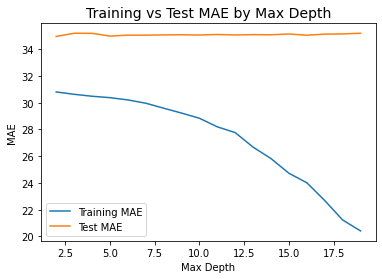

In [14]:
plt.title("Training vs Test MAE by Max Depth", fontdict={"fontsize": 14})
plt.xlabel("Max Depth", fontsize=10)
plt.ylabel("MAE", fontsize=10)

sns.lineplot(range(2, 20), training_mae, label="Training MAE")
sns.lineplot(range(2, 20), test_mae, label="Test MAE")
plt.legend()
plt.show()

The model requires further tuning and more predictors clearly. The MAPE is really bad.

# Example data point prediction

In [15]:
# New data point
new = pd.DataFrame(
    {
        "MATERIAL_CONTENT_CODE": ["AT2F"],
        "PRODUCT_TYPES": [1],
        "BUSINESS_SEGMENTS": [30308],
        "NRF_COLOR_CODE": [734],
        "Sustainablity": ["Low carbon footprint"],
        "MARKETING_CATEGORY": ["P219"],
        "Units_sold": [np.nan],
    }
)

In [16]:
# Feature nrf color group
new["nrf_color_group"] = new.apply(get_nrf_color_group, axis=1)

# Categorical encoding
new = oe_encoder.transform(new)
new = encoder.transform(new)

est_gb.predict(new[MODEL_FEATURES])

array([83.34933931])

In [17]:
# Serialize the model
gb_model_path = base_dir / "artifacts" / "gb_model.pkl"
file = open(gb_model_path, "wb")
pickle.dump(est_gb, file)